# **ĐỒ ÁN: NHẬP MÔN KHOA HỌC DỮ LIỆU** #

### Nhóm 7 ###
|<div style="width:150px">MSSV</div>|<div style="width:290px">Tên</div>|
|---------- |:-------------:|
| 20120041  |  Trần Kim Bảo |
| 20120053  |    Nguyễn Thành Đạt   | 
| 20120071  | Nguyễn Thị Bích Hà |
| 20120113  | Lê Nguyên Khang |

## <font color='orange'> Import thư viện </font> ##

In [1]:
!pip install scrapy
!pip install spider3

In [1]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import scrapy
from pandas.testing import assert_frame_equal # to compare two dataframes
# YOUR CODE HERE (OPTION) 
# Nếu cần các thư viện khác thì bạn có thể import thêm tại đây

## <font color='orange'> Mô tả trang web </font> ##

Trong đồ án này nhóm mình xin được giới thiệu đến mọi người danh sách phim hay nhất mọi thời đại *(Thời gian tính đến ngày 19/11/2022)* được trang IMDb tổng hợp. **IMDb** (<font color='blue'>https://www.imdb.com/</font>) là một trang cơ sở dữ liệu trực tuyến về điện ảnh thế giới, cung cấp thông tin về phim, diễn viên, đạo diễn, nhà làm phim,.. và tất cả những người, công ty trong lĩnh vực sản xuất phim, phim truyền hình và cả trò chơi video.

Những thông tin được thu thập tại website: <font color='blue'>https://www.imdb.com/list/ls006266261/</font>

### Tạo một project mới với scrapy ###

In [2]:
!scrapy startproject film_crawler

Error: scrapy.cfg already exists in d:\KHDL\Lab_CK\film_crawler


In [3]:
cd film_crawler/film_crawler

d:\KHDL\Lab_CK\film_crawler\film_crawler


---

## <font color='orange'> Thu thập thông tin từ web </font> ##
**<h5>1. Thu thập url, id, votes, gross của các phim </h5>**

In [4]:
%%writefile spiders/collect_film_urls.py
import scrapy

class collect_film_url(scrapy.Spider):
  name='film_urls' 
  
  def start_requests(self):
    urls=['https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page=1']
    self.page=1
    yield scrapy.Request(url=urls[0], callback=self.parse)
        
  def parse(self, response):
    stt=response.css('div.lister-list span.lister-item-index.unbold.text-primary::text').getall()
    id=response.css('div.lister-list img::attr(data-tconst)').getall()
    url=response.css('div.lister-list div.lister-item.mode-detail div.lister-item-image.ribbonize a::attr(href)').re(r'.*/title/.*\d{4,10}.')
    for i in range(len(stt)):
      yield{
        'STT': stt[i],
        'ID':id[i],
        'URL':url[i],
        'Votes':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[2]/@data-value').get(),
        'Gross':response.xpath(f'//*[@id="main"]/div/div[4]/div[3]/div[{i+1}]/div[2]/p[4]/span[5]/@data-value').get()
      }
    if self.page<11:
      self.page+=1
      next_page_url=f'https://www.imdb.com/list/ls006266261/?sort=list_order,asc&st_dt=&mode=detail&page={self.page}'
      yield scrapy.Request(url=next_page_url, callback=self.parse)
      

Overwriting spiders/collect_film_urls.py


- **Xuất các thông tin đã thu thập ở trên ra file json**

In [49]:
!scrapy crawl film_urls -o dataset/film_urls.json

2022-12-09 17:34:15 [scrapy.utils.log] INFO: Scrapy 2.6.3 started (bot: film_crawler)
2022-12-09 17:34:15 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 2.0.1, Twisted 22.8.0, Python 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)], pyOpenSSL 22.1.0 (OpenSSL 3.0.5 5 Jul 2022), cryptography 38.0.1, Platform Windows-10-10.0.22000-SP0
2022-12-09 17:34:15 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'film_crawler',
 'NEWSPIDER_MODULE': 'film_crawler.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['film_crawler.spiders']}
2022-12-09 17:34:16 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2022-12-09 17:34:16 [scrapy.extensions.telnet] INFO: Telnet Password: ff395e575e423eeb
2022-12-09 17:34:16 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.feedexp

In [5]:
%%writefile spiders/collect_data_films.py
import scrapy
import pandas as pd
import numpy as np
from selenium import webdriver

class collect_data_film(scrapy.Spider):
  name='data_film'
  def __init__(self):
    try:
      df = pd.read_json('./dataset/film_urls.json', encoding='utf-8-sig')
      self.urls=df['URL']
    except IOError:
      print("File not found")
  def start_requests(self):
    self.headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:48.0) Gecko/20100101 Firefox/48.0'}
    # CALOS
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt1321865/?ref_=ttls_li_tt'
    # JFK
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt0102138/?ref_=ttls_li_tt'
    # THE FIRM
    # scrapy shell -s USER_AGENT='custom user agent' 'https://www.imdb.com/title/tt0095158/?ref_=ttls_li_tt'
    for i in range(1000):
      next_page_url=f'https://www.imdb.com{self.urls[i]}?ref_=ttls_li_tt'
      yield scrapy.Request(url=next_page_url, callback=self.parse,headers=self.headers)

  def parse(self, response):

    # ID
    id_film=response.css('a.ipc-lockup-overlay.ipc-focusable::attr(href)').re(r'\w*\d{4,10}')[0]
    # Name
    name=response.css('h1[data-testid="hero-title-block__title"]::text').get()
    # Year release
    published_year=response.css("a[href*=releaseinfo]::text").re(r'\d{4}')[0]
    # Rate age
    age_rated=response.css("a[href*=certificates]::text").get()
    # Duration
    duration=response.css('div.ipc-metadata-list-item__content-container::text').getall()
    # Genres
    genres=response.css("a[href*=genres] span.ipc-chip__text::text").getall()
    
    # Director
    Director=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Director')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Writes
    Writers=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Writer')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    # Stars
    Stars=set(response.xpath('//*[@id="__next"]/main/div/section[1]/section/div[3]').xpath(".//*[contains(text(),'Star')]").xpath('following-sibling::div/ul/li/a/text()').getall())
    
    # Budget
    try:
      Budget=response.xpath(".//*[contains(text(),'Budget')]").xpath('following-sibling::div/ul/li/label/text()').re(r'^.?.*\s')[0]
    except:
      Budget=None

    #  IMDb rating
    IMDb_rating = response.css("span.sc-7ab21ed2-1::text").get()
    # Popularity
    popularity = response.css("div.sc-edc76a2-1::text").get()
    # User reviews
    user_reviews = response.xpath('//div[3]/div[2]/div[2]/ul/li[1]/a/span/span[1]/text()').get()
    # Critic reviews
    critic_reviews = response.xpath('//div[3]/div[2]/div[2]/ul/li[2]/a/span/span[1]/text()').get()
    # Metascore
    meta_score = response.xpath('//div[3]/div[2]/div[2]/ul/li[3]/a/span/span[1]/span/text()').get()
    # Oscar wins
    wins = response.css("a[href*=awards]::text").get()
  
    yield {
      'ID':id_film,
      'Name':name,
      'Published Year':published_year,
      'Rated':age_rated,
      'Duration':duration,
      'Genres':genres,
      
      'Director':Director,
      'Writers':Writers,
      'Stars':Stars,
      'Budget (estimated)':Budget,
      
      "IMDb RATING": IMDb_rating,
      "Popularity" : popularity,
      "User reviews": user_reviews,
      "Critic reviews": critic_reviews,
      "Meta score": meta_score,
      "Wins": wins,
    }

Overwriting spiders/collect_data_films.py


In [7]:
!scrapy crawl data_film -o dataset/data_film.json

2022-12-09 17:47:27 [scrapy.utils.log] INFO: Scrapy 2.6.3 started (bot: film_crawler)
2022-12-09 17:47:27 [scrapy.utils.log] INFO: Versions: lxml 4.9.1.0, libxml2 2.9.12, cssselect 1.1.0, parsel 1.6.0, w3lib 2.0.1, Twisted 22.8.0, Python 3.10.7 (tags/v3.10.7:6cc6b13, Sep  5 2022, 14:08:36) [MSC v.1933 64 bit (AMD64)], pyOpenSSL 22.1.0 (OpenSSL 3.0.5 5 Jul 2022), cryptography 38.0.1, Platform Windows-10-10.0.22000-SP0
2022-12-09 17:47:27 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'film_crawler',
 'NEWSPIDER_MODULE': 'film_crawler.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['film_crawler.spiders']}
2022-12-09 17:47:27 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2022-12-09 17:47:27 [scrapy.extensions.telnet] INFO: Telnet Password: 521b30955e3e5e61
2022-12-09 17:47:27 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.feedexp

---

## <font color='orange'> Khám phá dữ liệu </font> ##

<h4>1. Đọc dữ liệu</h4>

- <h5>Đọc file film_urls vào dataframe<h5>

In [6]:
df_url=pd.read_json('dataset/film_urls.json',encoding='utf-8-sig')
df_url.head()

,STT,ID,URL,Votes,Gross
0,1.,tt0068646,/title/tt0068646/,1849463,"134,966,411"
1,2.,tt0099685,/title/tt0099685/,1156922,"46,836,394"
2,3.,tt0110912,/title/tt0110912/,2043441,"107,928,762"
3,4.,tt0114814,/title/tt0114814/,1083363,"23,341,568"
4,5.,tt0078788,/title/tt0078788/,666884,"83,471,511"


- <h5>Đọc file data_film vào dataframe</h5>

In [7]:
df_film=pd.read_json('dataset/data_film.json',encoding='utf-8-sig')
df_film.head()

,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,tt0108052,Schindler's List,1993,R,"[3, , hours, , 15, , minutes]","[Biography, Drama, History]",[Steven Spielberg],"[Steven Zaillian, Thomas Keneally]","[Liam Neeson, Ben Kingsley, Ralph Fiennes]","$22,000,000",9.0,219,2.1K,175,94.0,Won 7 Oscars
2,tt0137523,Fight Club,1999,R,"[2, , hours, , 19, , minutes]",[Drama],[David Fincher],"[Chuck Palahniuk, Jim Uhls]","[Edward Norton, Meat Loaf, Brad Pitt]","$63,000,000",8.8,139,4.3K,373,66.0,Nominated for 1 Oscar
3,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


- <h5>Hợp dữ liệu lại</h5>

In [8]:
film_info_df=df_url.merge(df_film, on="ID", how="outer")
film_info_df.shape

(1000, 20)

In [9]:
film_info_df.head()

,STT,ID,URL,Votes,Gross,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,Budget (estimated),IMDb RATING,Popularity,User reviews,Critic reviews,Meta score,Wins
0,1.,tt0068646,/title/tt0068646/,1849463,"134,966,411",The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]","$6,000,000",9.2,92,5.2K,193,100.0,Won 3 Oscars
1,2.,tt0099685,/title/tt0099685/,1156922,"46,836,394",Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]","$25,000,000",8.7,194,1.5K,163,90.0,Won 1 Oscar
2,3.,tt0110912,/title/tt0110912/,2043441,"107,928,762",Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]","$8,000,000",8.9,115,3.5K,306,94.0,Won 1 Oscar
3,4.,tt0114814,/title/tt0114814/,1083363,"23,341,568",The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]","$6,000,000",8.5,425,1.4K,154,77.0,Won 2 Oscars
4,5.,tt0078788,/title/tt0078788/,666884,"83,471,511",Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]","$31,500,000",8.5,307,1.3K,302,94.0,Won 2 Oscars


- <h5>Ta thấy các cột như URL, Votes, Gross đứng đầu bảng thì rất khó quan sát, để dễ  quan sát và kiểm tra hơn, chúng ta cùng sắp xếp lại các cột nào</h5>

In [10]:
film_info_df=film_info_df[['STT','ID','Name','Published Year','Rated','Duration','Genres','Director','Writers','Stars','IMDb RATING'\
    ,'Budget (estimated)','Gross','Popularity','Votes','User reviews','Critic reviews','Meta score','Wins','URL']]

In [11]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, Marlon Brando, James Caan]",9.2,"$6,000,000","134,966,411",92,1849463,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Nicholas Pileggi, Martin Scorsese]","[Ray Liotta, Robert De Niro, Joe Pesci]",8.7,"$25,000,000","46,836,394",194,1156922,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Samuel L. Jackson, Uma Thurman, John Travolta]",8.9,"$8,000,000","107,928,762",115,2043441,3.5K,306,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Kevin Spacey, Gabriel Byrne]",8.5,"$6,000,000","23,341,568",425,1083363,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[Michael Herr, Francis Ford Coppola, John Milius]","[Martin Sheen, Marlon Brando, Robert Duvall]",8.5,"$31,500,000","83,471,511",307,666884,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


In [12]:
film_info_df[film_info_df.Popularity.isnull()]

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
28,29.,tt1235166,A Prophet,2009,R,"[2, , hours, , 35, , minutes]","[Crime, Drama]",[Jacques Audiard],"[Thomas Bidegain, Abdel Raouf Dafri, Jacques A...","[Tahar Rahim, Niels Arestrup, Adel Bencherif]",7.8,"$13,000,000","2,084,637",None,99084,174,264,90.0,Nominated for 1 Oscar,/title/tt1235166/
83,84.,tt0310793,Bowling for Columbine,2002,R,"[2, , hours]","[Documentary, Crime, Drama]",[Michael Moore],[Michael Moore],"[Charlton Heston, Marilyn Manson, Michael Moore]",8.0,"$4,000,000","21,576,018",None,145162,897,208,72.0,Won 1 Oscar,/title/tt0310793/
125,126.,tt0475276,United 93,2006,R,"[1, , hour, , 51, , minutes]","[Action, Drama, History]",[Paul Greengrass],[Paul Greengrass],"[Olivia Thirlby, David Alan Basche, Liza Colón...",7.6,"$15,000,000","31,567,134",None,107138,892,147,90.0,Nominated for 2 Oscars,/title/tt0475276/
127,128.,tt0120706,The General,1998,R,"[2, , hours, , 4, , minutes]","[Biography, Crime, Drama]",[John Boorman],"[Paul Williams, John Boorman]","[Brendan Gleeson, Adrian Dunbar, Sean McGinley]",7.2,None,"1,211,865",None,8862,51,54,81.0,Awards,/title/tt0120706/
131,132.,tt0114660,Things to Do in Denver When You're Dead,1995,R,"[1, , hour, , 55, , minutes]","[Crime, Drama, Thriller]",[Gary Fleder],[Scott Rosenberg],"[Christopher Lloyd, Andy Garcia, Christopher W...",6.7,"$7,000,000","529,766",None,28181,165,45,46.0,Awards,/title/tt0114660/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,970.,tt0070707,Sleeper,1973,PG,"[1, , hour, , 29, , minutes]","[Comedy, Sci-Fi]",[Woody Allen],"[Woody Allen, Marshall Brickman]","[Woody Allen, Diane Keaton, John Beck]",7.1,"$2,000,000","2,905,334",None,43336,143,68,77.0,Awards,/title/tt0070707/
971,972.,tt2870648,Amy,2015,R,"[2, , hours, , 8, , minutes]","[Documentary, Biography, Music]",[Asif Kapadia],[],"[Amy Winehouse, Mitch Winehouse, Mark Ronson]",7.8,None,"8,413,144",None,52575,140,258,85.0,Won 1 Oscar,/title/tt2870648/
989,990.,tt1152758,Dear Zachary: A Letter to a Son About His Father,2008,Not Rated,"[1, , hour, , 35, , minutes]","[Documentary, Biography, Crime]",[Kurt Kuenne],[Kurt Kuenne],"[David Bagby, Kurt Kuenne, Andrew Bagby]",8.5,None,"20,834",None,37353,146,73,82.0,Awards,/title/tt1152758/
991,992.,tt5895028,13th,2016,TV-MA,"[1, , hour, , 40, , minutes]","[Documentary, Crime, History]",[Ava DuVernay],"[Ava DuVernay, Spencer Averick]","[Michelle Alexander, Cory Booker, Melina Abdul...",8.2,None,None,None,35837,120,101,83.0,Nominated for 1 Oscar,/title/tt5895028/


<h4>2. Bắt đầu khám phá dữ liệu</h4>

- <h5>Kiểm tra xem có dữ liệu trùng nhau không (<em>Ở đây ID mang tính định danh cho từng phim, ta sẽ kiểm tra xem thử có ID phim nào trùng nhau không</em>)</h5>

In [13]:
check_duplucate=set(film_info_df.ID.duplicated())
if True in check_duplucate:
    have_duplicated_rows = True
else:
    have_duplicated_rows = False

In [14]:
# TEST
assert have_duplicated_rows == False

<h4> Ý nghĩa mỗi dòng:</h4>

- Là thông tin chi tiết của các phim trong [top 1000 phim hay nhất mọi thời đại](https://www.imdb.com/list/ls006266261/), được [IMDb](https://www.imdb.com/?ref_=nv_home)  tổng hợp.


<h4>Ý nghĩa mỗi cột:</h4>

- Top: thể hiện vị thứ của phim trong danh sách
- ID: là duy nhất và mang tính định danh cho phim
- Name: tên của phim
- Published Year: Năm đầu tiên ra mắt phim
- Rated: 
- Duration: Thời gian phim
- Genres: Thể loại mà phim thuộc về
- Director: Đạo diễn sản xuất phim
- Writers: 
- Stars: Diễn viên nổi tiếng tham gia(ở đây nhóm chỉ lấy 1 vài người)
- IMDb RATING: Điểm đánh giá của IMDb về phim
- Budget (estimated): Kinh phí thực hiện phim (ước tính)
- Gross: Doanh thu của phim
- Popularity: Xếp hạng tổng quát
- Votes: Số lượt bình chọn
- User reviews: Số lượng nhận xét của người xem
- Critic reviews: Số lượng nhận xét của nhà phê bình
- Meta score:
- Wins: Giải mà phim đạt được trong các cuộc thi
- URL: địa chỉ truy cập vào trang web mô tả chi tiết của phim
- Votes: số lượt bình chọn cho phim
- Gross: Thu nhập của phim tính đến thời điểm hiện tại


<h4>Kiểm tra xem mỗi cột hiện đang có kiểu dữ liệu gì?</h4>

In [22]:
# YOUR CODE HERE

<h4>Khoảng biểu diễn của kiểu dữ liệu đó như thế nào?</h4>

In [23]:
# YOUR CODE HERE

<h4>Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp hay không?</h4>

In [24]:
# YOUR CODE HERE

<h4>Với mỗi cột, dữ liệu phân bố như thế nào?</h4>

Thực hiện chuyển dối cột Duration về dạng float

vd: ["2", "h", " ", "55", "m"] -> 175 

In [21]:
def transform_duration(duration):
    if (len(duration) == 3):
        tmp_dur = duration[0]
        tmp_dur = float(tmp_dur) * 60
        return tmp_dur
    elif (len(duration) == 7):
        tmp_dur1 = duration[0] 
        tmp_dur1 = float(tmp_dur1) * 60

        tmp_dur2 = duration[4] 
        tmp_dur2 = float(tmp_dur2)
        tmp_dur = tmp_dur1 + tmp_dur2
        return tmp_dur    

In [22]:
film_info_df['Duration'] = film_info_df['Duration'].apply(transform_duration)

In [23]:
# TEST
assert film_info_df['Duration'].dtype in [np.float32, np.float64]

Thực hiện chuyển đổi cột Budget (estimated) về dạng float 

vd: '$6,000,000' -> 6000000

In [24]:
def exchange_rate(currency):
    currency = str(currency)
    l = len(currency)
    if currency == 'None':
        bbudget = 0
        tmp_cur = '0'
    elif currency[0] == '$':
        bbudget = 1
        tmp_cur = currency[1:l]
    elif currency[0] == '£':
        bbudget = 1.22
        tmp_cur = currency[1:l]
    elif currency[0] == '€':
        bbudget = 1.05
        tmp_cur = currency[1:l]
    elif currency[0] == '¥':
        bbudget = 0.0073
        tmp_cur = currency[1:l]
    elif currency[0] == '₹':
        bbudget = 0.012
        tmp_cur = currency[1:l]
    elif currency[0:2] == 'R$':
        bbudget = 0.19
        tmp_cur = currency[2:l]
    elif currency[0:2] == 'A$':
        bbudget = 0.68
        tmp_cur = currency[2:l]
    elif currency[0:3] == 'CA$':
        bbudget = 0.74
        tmp_cur = currency[3:l]
    else:
        currency = str(currency)
        tmp_currency = currency.split()
        if tmp_currency[0] == 'FRF':
            bbudget = 0.161
        elif tmp_currency[0] == 'DEM':
            bbudget = 0.54
        elif tmp_currency[0] == 'NOK':
            bbudget = 0.1
        elif tmp_currency[0] == 'MVR':
            bbudget = 0.065
        tmp_cur = currency[4: l]
    tmp_cur = tmp_cur.replace(' ', '')
    tmp_cur = tmp_cur.replace(',', '')
    tmp_cur = float(tmp_cur)
    tmp_cur = tmp_cur*bbudget
    return tmp_cur

In [25]:
film_info_df["Budget (estimated)"] = film_info_df["Budget (estimated)"].apply(exchange_rate)

In [ ]:
# TEST
assert film_info_df['Budget (estimated)'].to_list()[:5] == [6000000.0, 25000000.0, 8000000.0, 6000000.0, 31500000.0]
assert film_info_df['Budget (estimated)'].to_list()[-5:] == [54000000.0, 25000000.0, 65000000.0, 8500000.0, 110000000.0]

In [52]:
film_info_df["Budget (estimated)"]

0        6000000.0
1       25000000.0
2        8000000.0
3        6000000.0
4       31500000.0
          ...     
995     54000000.0
996     25000000.0
997     65000000.0
998      8500000.0
999    110000000.0
Name: Budget (estimated), Length: 1000, dtype: float64

Thực hiện chuyển đổi cột Gross về dạng float 

In [26]:
def Gross_to_float(col_df):
    col_convert = []
    for i in film_info_df['Gross']:
        if (str(i) != 'None'):
            gross = str(i)
            # gross = gross.replace(' ', '')
            gross = gross.replace(',', '')
            gross = float(gross)
            col_convert.append(gross)
        else:
            col_convert.append(0.0)
    film_info_df['Gross'] = col_convert

Gross_to_float(film_info_df['Gross'])


Thực hiện chuyển đổi cột Popularity về dạng int 

In [27]:
def Popularity_to_int(col_df):
    col_convert = []
    for i in film_info_df['Popularity']:
        if (str(i) != 'None'):
            popularity = str(i)
            popularity = popularity.replace(',', '')
            popularity = int(popularity)
            col_convert.append(popularity)
        else:
            col_convert.append(0)
    film_info_df['Popularity'] = col_convert

Popularity_to_int(film_info_df['Popularity'])


Thực hiện chuyển đổi cột User reviews về dạng float 

In [28]:
def User_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['User reviews']:
        if (str(i) != 'None'):
            Usr = str(i)
            if Usr[-1] == 'K':
                Usr = Usr.replace('K', '')
                Usr = float(Usr) * 1000
                col_convert.append(Usr)
            else:
                col_convert.append(float(Usr))
        else:
            col_convert.append(0.0)
    film_info_df['User reviews'] = col_convert

User_reviews_to_float(film_info_df['User reviews'])

Thực hiện chuyển đổi cột Critic reviews về dạng float 

In [29]:
def Critic_reviews_to_float(col_df):
    col_convert = []
    for i in film_info_df['Critic reviews']:
        if (str(i) != 'None'):
            Crr = str(i)        
            if Crr[-1] == 'K':
                Crr = Crr.replace('K', '')
                Crr = float(Crr) * 1000
            else:
                Crr = float(Crr)
            col_convert.append(Crr)
        else:
            col_convert.append(0.0)
    film_info_df['Critic reviews'] = col_convert

Critic_reviews_to_float(film_info_df['Critic reviews'])

### Với mỗi cột có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [ ]:
film_info_df.info()

In [32]:
# YOUR CODE HERE
col = [] 
for i in film_info_df.columns: 
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        col.append([])

def get_median(median, index, l, r):
    ll = r - l
    if ll % 2 != 0:
        return(median[index + ll//2])
    else:
        return((median[index + ll//2 - 1] + median[index + ll//2]) / 2)

len_col = len(film_info_df["Name"])

columee = []  
count = -1
for i in film_info_df.columns:
    missing_ratio = 0
    median = []
    minn = 1000000000
    maxx = 0
    if film_info_df[i].dtype in [np.float32, np.float64] or film_info_df[i].dtype in [np.int32, np.int64]:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'nan'):
                missing_ratio += 1
            if minn > j :
                minn = j
            if (str(j) != 'nan'):
                median.append(j)
            if maxx < j :
                maxx = j

        col[count].append(round(missing_ratio*100 / len_col, 1))
        col[count].append(minn)

        median = sorted(median)
        ll = len(median) 

        mid = (0 + ll)//2
        if ll % 2 != 0 : 
            col[count].append(get_median(median, 0, 0, int(mid)))
        else:
            col[count].append(get_median(median, 0, 0, int(mid)))

        ll = len(median)
        if ll % 2 != 0:
            col[count].append(median[ll//2])
        else:
            col[count].append((median[ll//2 - 1] + median[ll//2]) / 2)

        if ll % 2 != 0 : 
            col[count].append(get_median(median, int(mid) + 1, int(mid) + 1, int(ll) ))
        else:
            col[count].append(get_median(median, int(mid), int(mid), int(ll) ))

        col[count].append(maxx)
        
 
num_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "min", "lower_quartile", "median", "upper_quartile", "max"]
num_col_info_df['indexx'] = indexx
num_col_info_df = num_col_info_df.set_index('indexx')

index_columee = 0
for i in columee:
    num_col_info_df[i] = col[index_columee]
    index_columee += 1

In [ ]:
num_col_info_df

### Với mỗi cột có kiểu dữ liệu không phải dạng số, các giá trị được phân bố như thế nào?

In [39]:
cols_film = ['Rated', 'Wins', 'Genres', 'Director', 'Writers', 'Stars']

# Các cột ứng với câu hỏi khảo sát multichoice
multichoice_cols = [ 'Genres', 'Director', 'Writers', 'Stars' ]

In [ ]:
pd.set_option('display.max_colwidth', 100) # Để dễ nhìn
pd.set_option('display.max_columns', None) # Để dễ nhìn
col = [] 

for i in film_info_df.columns: 
    if i in cols_film:
        col.append([])

len_col = len(film_info_df['Genres'])
count = -1
used = []
columee = []
for i in film_info_df.columns:
    used.clear()
    missing_ratio = 0
    num_values = 0
    if i in cols_film:
        columee.append(i)
        count += 1
        for j in film_info_df[i]: 
            if (str(j) == 'None'):
                missing_ratio += 1

        col[count].append(round(missing_ratio*100 / len_col, 1))

        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in used):
                    used.append(j)
                    num_values += 1
            col[count].append(num_values)
        else:
            for j in film_info_df[i]:
                if (str(j) != 'None'):
                    for k in j:
                        if (k not in used):
                            used.append(k)
                            num_values += 1
            col[count].append(num_values)

        dictCol = {}
        count_key = 0
        if i not in multichoice_cols:
            for j in film_info_df[i]: 
                if (str(j) != 'None' and j not in dictCol):
                    dictCol[j] = 1
                    count_key += 1
                elif str(j) != 'None':
                    dictCol[j] = dictCol[j] +1
                    count_key += 1
        else:
            for j in film_info_df[i]: 
                if (str(j) != 'None'):
                    # tmp = j.split(';')
                    for k in j:
                        if (k not in dictCol):
                            dictCol[k] = 1
                            count_key += 1
                        else:
                            dictCol[k] = dictCol[k] +1
                            count_key += 1
        for j in dictCol:
            dictCol[j] = round(dictCol[j]*100 / count_key, 1)

        items_sorted = sorted(dictCol.items(),reverse=True, key = lambda x : x[1]) # sắp xếp từ điển giảm dần 
        dictCol_sort = {}
        for i in items_sorted :
            dictCol_sort[i[0]] = i[1]

        col[count].append(dictCol)        

cat_col_info_df = pd.DataFrame()
indexx = ["missing_ratio", "num_values", "value_ratios"]
cat_col_info_df['indexx'] = indexx
cat_col_info_df = cat_col_info_df.set_index('indexx')

index_columee = 0
for i in columee:
    cat_col_info_df[i] = col[index_columee]
    index_columee += 1

In [51]:
cat_col_info_df

,Rated,Genres,Director,Writers,Stars,Wins
indexx,,,,,,
missing_ratio,0.3,0.0,0.0,0.0,0.0,1.6
num_values,13,22,579,1388,1739,29
value_ratios,"{'R': 57.9, 'PG': 10.7, 'PG-13': 18.0, 'G': 2.5, 'NC-17': 0.8, 'X': 0.3, 'Approved': 1.6, 'Not R...","{'Crime': 11.4, 'Drama': 22.2, 'Biography': 4.1, 'Mystery': 4.5, 'War': 0.9, 'History': 1.3, 'Th...","{'Francis Ford Coppola': 0.5, 'Martin Scorsese': 1.6, 'Quentin Tarantino': 0.8, 'Bryan Singer': ...","{'Francis Ford Coppola': 0.2, 'Mario Puzo': 0.2, 'Nicholas Pileggi': 0.1, 'Martin Scorsese': 0.1...","{'Al Pacino': 0.5, 'Marlon Brando': 0.1, 'James Caan': 0.1, 'Ray Liotta': 0.1, 'Robert De Niro':...","{'Won 3 Oscars': 2.6, 'Won 1 Oscar': 10.8, 'Won 2 Oscars': 4.8, 'Nominated for 1 Oscar': 11.8, '..."


---

## <font color='orange'> Tiền xử lý </font> ##

In [22]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1.,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000","134,966,411",92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2.,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000","46,836,394",194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3.,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000","107,928,762",115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4.,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000","23,341,568",425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5.,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000","83,471,511",307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


- <h5>Ta thấy ở cột STT, Gross đang ở kiểu object, nhưng đúng là ở dạng numberic, ta thực hiện tiền xử lý về đúng kiểu dữ liệu</h5>

In [23]:
film_info_df.STT=film_info_df.STT.replace(',','',regex=True).replace('\.','',regex=True).astype(int)
film_info_df.Gross=film_info_df.Gross.replace([",",None],['',np.nan],regex=True).astype(float)

In [24]:
display(film_info_df)

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,tt0187738,Blade II,2002,R,"[1, , hour, , 57, , minutes]","[Action, Horror, Sci-Fi]",[Guillermo del Toro],"[Gene Colan, David S. Goyer, Marv Wolfman]","[Ron Perlman, Kris Kristofferson, Wesley Snipes]",6.7,"$54,000,000",82348319.0,"2,463",220651,613,221,52.0,Awards,/title/tt0187738/
996,997,tt0106856,Falling Down,1993,R,"[1, , hour, , 53, , minutes]","[Action, Crime, Drama]",[Joel Schumacher],[Ebbe Roe Smith],"[Michael Douglas, Robert Duvall, Barbara Hershey]",7.6,"$25,000,000",40903593.0,"1,362",191614,523,96,56.0,Awards,/title/tt0106856/
997,998,tt0120663,Eyes Wide Shut,1999,TV-MA,"[2, , hours, , 39, , minutes]","[Drama, Mystery, Thriller]",[Stanley Kubrick],"[Frederic Raphael, Arthur Schnitzler, Stanley ...","[Todd Field, Tom Cruise, Nicole Kidman]",7.5,"$65,000,000",55691208.0,206,342951,1.7K,284,68.0,Awards,/title/tt0120663/
998,999,tt0093437,The Lost Boys,1987,R,"[1, , hour, , 37, , minutes]","[Comedy, Horror]",[Joel Schumacher],"[Jeffrey Boam, Jan Fischer, James Jeremias]","[Jason Patric, Corey Haim, Dianne Wiest]",7.2,"$8,500,000",32222567.0,"1,207",145833,486,174,63.0,Awards,/title/tt0093437/


In [25]:
film_info_df.Rated.value_counts()

R            577
PG-13        179
PG           107
Not Rated     54
G             25
Approved      16
Passed        15
NC-17          8
Unrated        5
GP             3
X              3
TV-14          3
TV-MA          2
Name: Rated, dtype: int64

In [26]:
film_info_df[film_info_df['Rated'].isnull()]

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
286,287,tt0082096,The Boat,1981,None,"[2, , hours, , 29, , minutes]","[Drama, War]",[Wolfgang Petersen],"[Wolfgang Petersen, Lothar G. Buchheim]","[Klaus Wennemann, Jürgen Prochnow, Herbert Grö...",8.4,"DEM 32,000,000",11487676.0,"1,595",251700,568,112,86.0,Nominated for 6 Oscars,/title/tt0082096/
645,646,tt1242422,Celda 211,2009,None,"[1, , hour, , 53, , minutes]","[Action, Crime, Drama]",[Daniel Monzón],"[Daniel Monzón, Francisco Pérez Gandul, Jorge ...","[Luis Tosar, Alberto Ammann, Antonio Resines]",7.6,"€3,500,000",NaN,None,68172,None,None,NaN,Awards,/title/tt1242422/
675,676,tt0296042,Ichi the Killer,2001,None,"[2, , hours, , 9, , minutes]","[Action, Crime, Drama]",[Takashi Miike],"[Hideo Yamamoto, Sakichi Sato]","[Nao Ômori, Tadanobu Asano, Shin'ya Tsukamoto]",7.0,"$1,400,000",20285.0,None,56875,327,109,55.0,Awards,/title/tt0296042/


In [27]:
film_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STT                 1000 non-null   int64  
 1   ID                  1000 non-null   object 
 2   Name                1000 non-null   object 
 3   Published Year      1000 non-null   int64  
 4   Rated               997 non-null    object 
 5   Duration            1000 non-null   object 
 6   Genres              1000 non-null   object 
 7   Director            1000 non-null   object 
 8   Writers             1000 non-null   object 
 9   Stars               1000 non-null   object 
 10  IMDb RATING         1000 non-null   float64
 11  Budget (estimated)  895 non-null    object 
 12  Gross               937 non-null    float64
 13  Popularity          782 non-null    object 
 14  Votes               1000 non-null   int64  
 15  User reviews        963 non-null    object 
 16  Critic 

---

## <font color='orange'> Câu hỏi đặt ra </font> ##

<h3>Bài 1:Phân tích trong khoảng 10 năm để tìm ra thể loại phim được ưu chuộng trong mỗi khoảng thời gian và có thể giải thích lí do:
Dựa vào việc tương quan giữa cột thể loại (genre) với lần lượt thông tin: doanh thu, lượt yêu thích (truy cập, độ nổi tiếng), điểm được chấm trên các tiêu chí khác nhau (mỗi tiêu chí là một cột).</h3>

Bài 1: 
- Phân tích trong 10 năm để tìm ra thể loại phim được yêu thích trong mỗi khoảng thời gian.
- Tương quan giữa các thể loại (genre) với doanh thu, truy cập, độ nổi tiếng, điểm được 

In [28]:
film_info_df.head()

,STT,ID,Name,Published Year,Rated,Duration,Genres,Director,Writers,Stars,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]","[Al Pacino, James Caan, Marlon Brando]",9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]","[Joe Pesci, Ray Liotta, Robert De Niro]",8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]","[Uma Thurman, John Travolta, Samuel L. Jackson]",8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],"[Chazz Palminteri, Gabriel Byrne, Kevin Spacey]",8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]","[Martin Sheen, Robert Duvall, Marlon Brando]",8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


- <h5>Kiểm tra xem thử có phim nào không có năm ra mắt không</h5>

In [29]:
film_info_df['Published Year'].isnull().any()

False

In [30]:
film_info_df['Published Year'].unique()

array([1972, 1990, 1994, 1995, 1979, 1996, 1999, 1993, 1997, 1992, 1975,
       1976, 1985, 1974, 2008, 1983, 2001, 1986, 1998, 1980, 2009, 2006,
       2002, 1984, 1973, 2000, 1981, 1988, 1942, 2010, 1987, 2005, 1971,
       2011, 1982, 1941, 2004, 2003, 1991, 1989, 2012, 1957, 1964, 2007,
       1946, 1977, 1966, 2013, 1978, 1969, 1967, 1939, 1954, 1968, 1960,
       2018, 2019, 1962, 1961, 2014, 2015, 2016, 1949, 1959, 1970, 2017,
       1955, 1950, 1956, 1963, 1958, 1940, 1948, 1965, 1938, 2020, 1952,
       1944, 1933, 1934, 1947])

- <h5>Chia khoảng các phim theo cụm 10 năm</h5>

In [31]:
def decade(vl):
       return int(np.floor(vl/10)*10)

film_info_df.insert(4,"Decade",film_info_df['Published Year'].apply(decade),True)

In [32]:
film_info_df.head()

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,...,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
0,1,tt0068646,The Godfather,1972,1970,R,"[2, , hours, , 55, , minutes]","[Crime, Drama]",[Francis Ford Coppola],"[Francis Ford Coppola, Mario Puzo]",...,9.2,"$6,000,000",134966411.0,92,1849023,5.2K,193,100.0,Won 3 Oscars,/title/tt0068646/
1,2,tt0099685,Goodfellas,1990,1990,R,"[2, , hours, , 25, , minutes]","[Biography, Crime, Drama]",[Martin Scorsese],"[Martin Scorsese, Nicholas Pileggi]",...,8.7,"$25,000,000",46836394.0,194,1156616,1.5K,163,90.0,Won 1 Oscar,/title/tt0099685/
2,3,tt0110912,Pulp Fiction,1994,1990,R,"[2, , hours, , 34, , minutes]","[Crime, Drama]",[Quentin Tarantino],"[Roger Avary, Quentin Tarantino]",...,8.9,"$8,000,000",107928762.0,115,2042809,3.5K,304,94.0,Won 1 Oscar,/title/tt0110912/
3,4,tt0114814,The Usual Suspects,1995,1990,R,"[1, , hour, , 46, , minutes]","[Crime, Drama, Mystery]",[Bryan Singer],[Christopher McQuarrie],...,8.5,"$6,000,000",23341568.0,425,1083153,1.4K,154,77.0,Won 2 Oscars,/title/tt0114814/
4,5,tt0078788,Apocalypse Now,1979,1970,R,"[2, , hours, , 27, , minutes]","[Drama, Mystery, War]",[Francis Ford Coppola],"[John Milius, Michael Herr, Francis Ford Coppola]",...,8.5,"$31,500,000",83471511.0,307,666748,1.3K,302,94.0,Won 2 Oscars,/title/tt0078788/


- <h5>Cùng vẽ biểu đồ  xem số lượng phim thay đổi thế nào giữa các thập kỉ nào</h5>

In [64]:
film_decade=film_info_df.Decade.value_counts().sort_index()
film_decade

1930      6
1940     16
1950     19
1960     39
1970     76
1980    124
1990    215
2000    282
2010    222
2020      1
Name: Decade, dtype: int64

In [65]:
film_info_df[film_info_df.Decade==2020]

,STT,ID,Name,Published Year,Decade,Rated,Duration,Genres,Director,Writers,...,IMDb RATING,Budget (estimated),Gross,Popularity,Votes,User reviews,Critic reviews,Meta score,Wins,URL
774,775,tt6723592,Tenet,2020,2020,PG-13,"[2, , hours, , 30, , minutes]","[Action, Sci-Fi, Thriller]",[Christopher Nolan],[Christopher Nolan],...,7.3,"$205,000,000",58456624.0,242,501780,5.5K,510,69.0,Won 1 Oscar,/title/tt6723592/


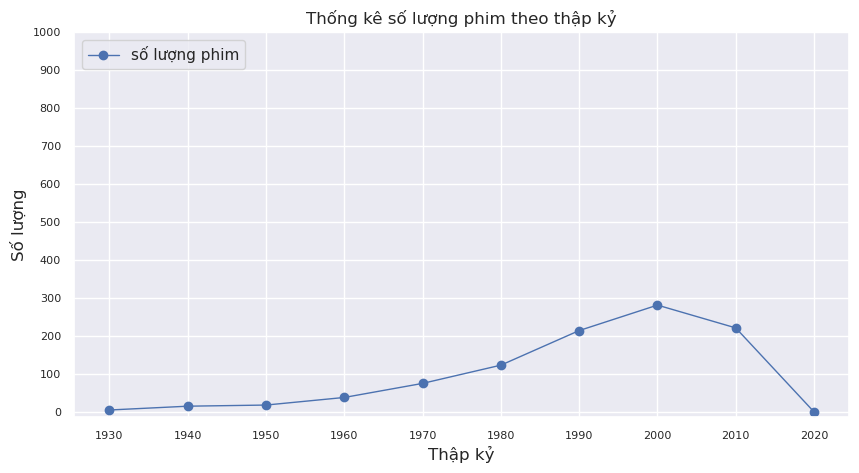

In [71]:

fig =plt.subplots(figsize=(10,5))

decade=np.array(film_decade.keys())
num_film=np.array(film_decade.values)

plt.plot(decade,num_film,marker='o',linestyle='-',linewidth=1,label='số lượng phim')
plt.xlabel('Thập kỷ')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thập kỷ')
plt.xticks(decade,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.legend(loc='upper left')
plt.show()

<h4>Nhận xét:</h4>

- Khi thực hiện đồ án, danh sách tổng hợp cập nhật lần gần nhất là 12/11/2021. Và với tình hình dịch bệnh các năm 2020, 2021 ở trên khắp thế giới, nên ta có thể thấy chỉ có 1 phim [Tenet](https://www.imdb.com/title/tt6723592/) là nằm trong [top 1000 phim](https://www.imdb.com/list/ls006266261/).<br>

- Và ta cũng có thể thấy được sự thay đổi rõ rệt về số lượng phim lọt top từ thập niên 1930 đến thập niên 2000 (tăng dần), tuy nhiên có 1 sự sụt giảm vào thập niên 2010 lúc công nghệ làm phim phát triển hơn hắn những thập niên trước (liệu rằng có yếu tố nào tác động đằng sau, chúng ta sẽ cố trả lời nó vào những câu hỏi sau nhé).


- <h5>Tiếp tục chia ra xem những thể loại nào nhiều nhất nhé</h5>

In [45]:
film_info_df.Genres.explode().unique()

array(['Crime', 'Drama', 'Biography', 'Mystery', 'War', 'History',
       'Thriller', 'Adventure', 'Comedy', 'Sci-Fi', 'Action', 'Sport',
       'Romance', 'Animation', 'Horror', 'Fantasy', 'Western', 'Family',
       'Documentary', 'Music', 'Film-Noir', 'Musical'], dtype=object)


<h4>Ở đây, ta thấy hơi lạ sao lại có 2 thể loại Music và Musical, liệu dữ liệu có bị trùng hay gì không?</h4>


<h4>Câu trả lời là <b>không</b> nhé:</h4>

- Music: thể loại có liên quan đến âm nhạc ví dụ như một câu chuyện về một bản nhạc, hay đại loại như vậy.</br>
- Musical: thể loại nhạc kịch, tràn đầy những bản nhạc, kết hợp với những điệu nhảy cuốn hút người xem.</br>

[Chi tiết](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG#)


In [67]:
film_genre=film_info_df.Genres.explode().value_counts()
film_genre

Drama          573
Crime          293
Comedy         279
Action         254
Thriller       191
Adventure      181
Mystery        117
Biography      106
Horror          93
Romance         92
Sci-Fi          91
Fantasy         56
Documentary     50
Animation       34
History         34
Music           31
War             24
Sport           23
Family          23
Western         17
Film-Noir        8
Musical          6
Name: Genres, dtype: int64

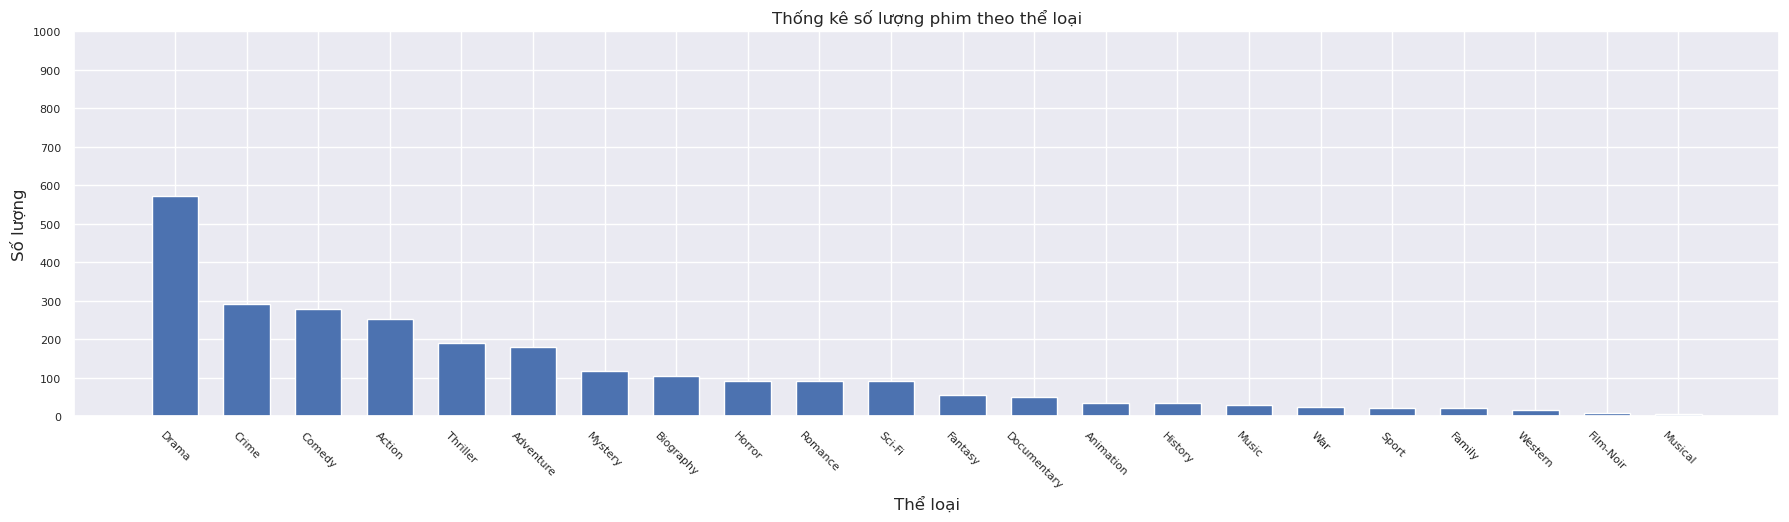

In [72]:
fig =plt.subplots(figsize=(22,5))

genre=np.array(film_genre.keys())
num_film=np.array(film_genre.values)

plt.bar(genre,num_film,width=0.65)
plt.xlabel('Thể loại')
plt.ylabel('Số lượng')
plt.title('Thống kê số lượng phim theo thể loại')
plt.xticks(genre,size=8)
plt.yticks(range(0,1001,100),size=8)
plt.setp(plt.gca().get_xticklabels(), rotation=-45, horizontalalignment='center')
plt.show()

<h4>Nhận xét:</h4>

- Nhìn biểu đồ ta thấy được xu hướng lọt top phim của các phim pha trộn(hoặc tập trung) vào thể loại drama chiếm hơn 1 nửa số lượng phim và cũng là thể loại chiếm số lượng cao nhất. Thể loại được kết hợp nhiều các yếu tố tâm lý xã hội, bi – hài tạo nên một tổng thể mang lại nhiều cảm xúc đan xen cho người xem.<br>
- Tiếp đến là các thể loại phổ biến như: phim tội phạm, hài kịch, hành động, giật gân, phiêu lưu: cũng là những thể loại chiếm đa số. Ở đây trừ hài kịch mục đích gây cười, có tính giải trí cao (*điều ai cũng cần*), thì có thể thấy gần như hầu hết đều là những thể loại mạnh mẽ, nhịp độ phim nhanh gây kích thích, hứng thú cho người xem.<br>
- Các thể loại còn lại chỉ chiếm từ 0 đến 10% số lượng phim trong danh sách.

In [40]:
film_info_df.explode('Genres').value_counts(['Decade','Genres']).sort_index()

Decade  Genres   
1930    Adventure     2
        Comedy        1
        Crime         2
        Drama         4
        Family        1
                     ..
2010    Thriller     42
        Western       3
2020    Action        1
        Sci-Fi        1
        Thriller      1
Length: 160, dtype: int64

- <h4>Cùng xem sự tương quan giữa thể loại phim từng thập niên như thế nào nhé(Như ở trên đã đề cập, ta sẽ không xét thập niên 2020)</h4>

In [78]:
film_genre_decade=film_info_df[~film_info_df.Decade.isin([2020])].explode('Genres').value_counts(['Decade','Genres']).to_frame().reset_index([0,1])
film_genre_decade

,Decade,Genres,0
0,2000,Drama,169
1,1990,Drama,131
2,2010,Drama,124
3,2000,Crime,82
4,2000,Action,80
...,...,...,...
152,1960,Sport,1
153,1960,Animation,1
154,1960,Fantasy,1
155,1960,History,1


<AxesSubplot:title={'center':'Tương quan giữa sự thay đổi của số lượng thể loại phim theo thập niên'}, xlabel='Thập niên', ylabel='Số lượng'>

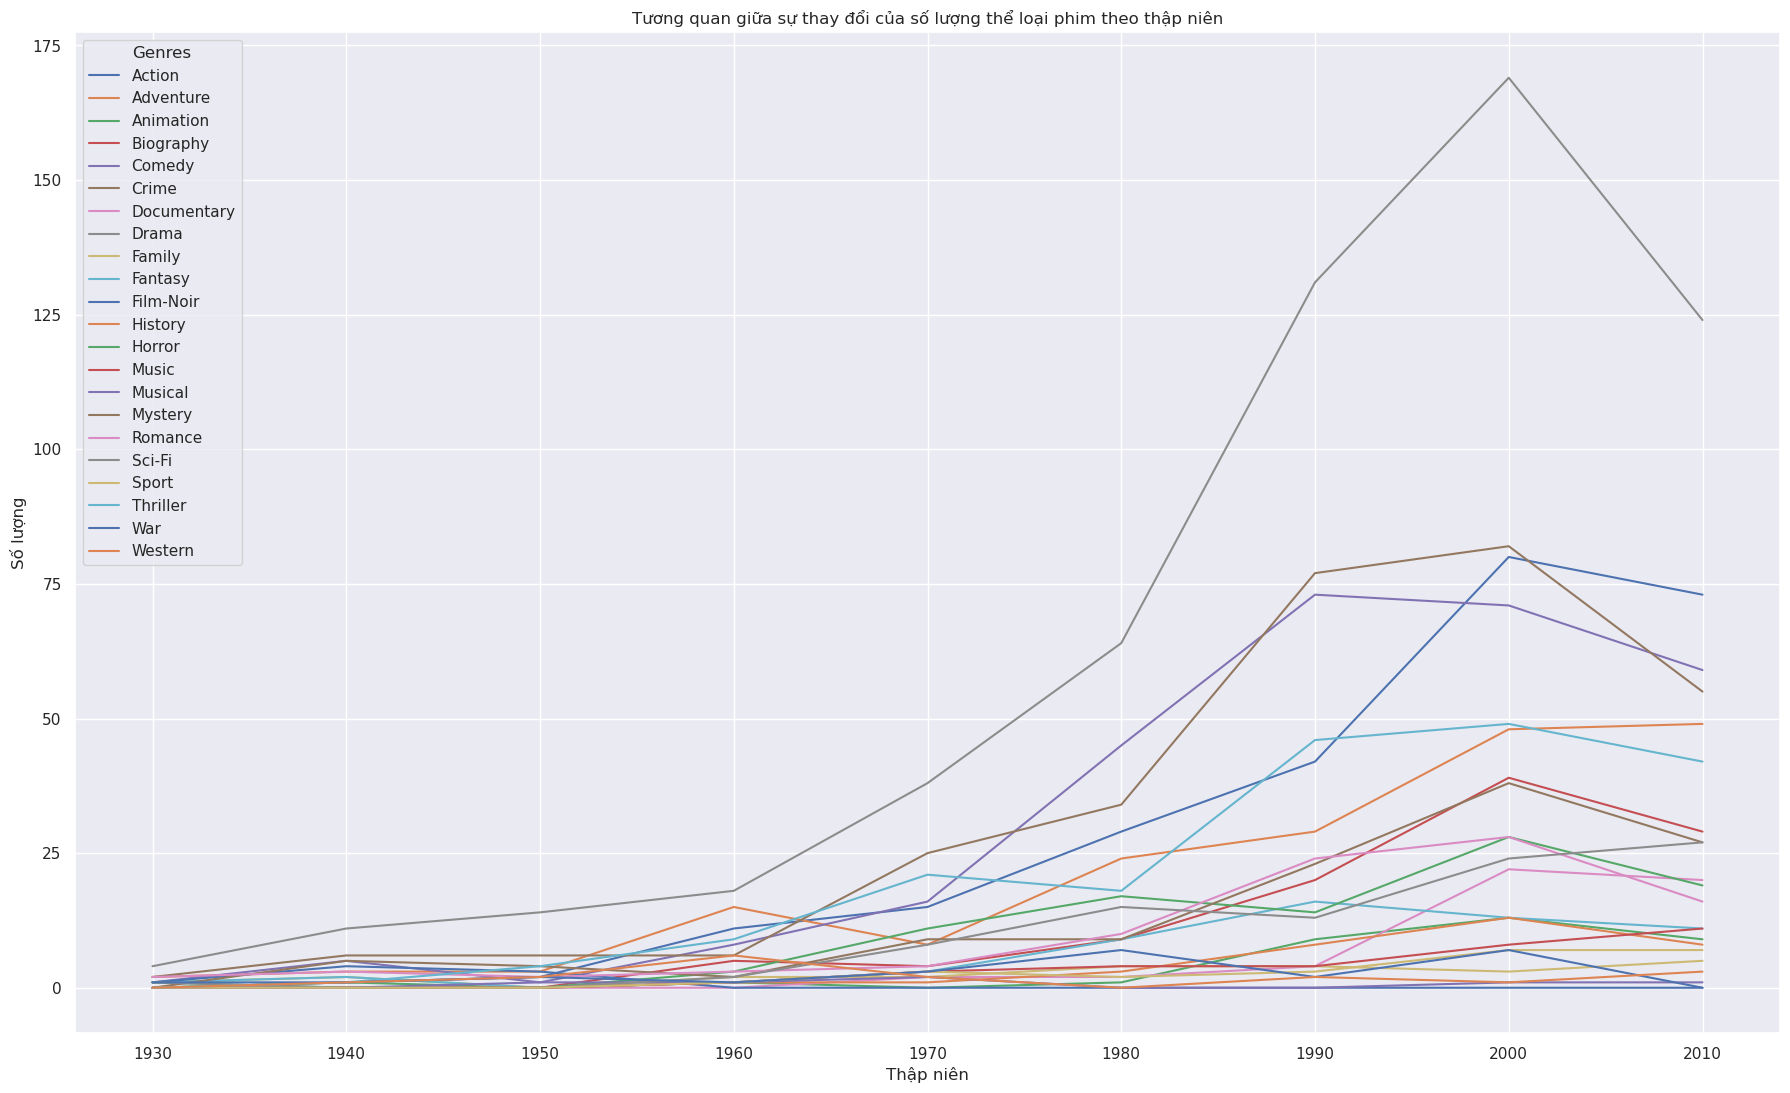

In [93]:
num_film_each_genre=film_genre_decade.pivot('Decade','Genres',0)
num_film_each_genre=num_film_each_genre.sort_index().fillna(0)

num_film_each_genre.plot(
    figsize=(22,13),
    xlabel='Thập niên',
    ylabel='Số lượng',
    title='Tương quan giữa sự thay đổi của số lượng thể loại phim theo thập niên'
)


<h1>NHẬN XÉT:</h1>

- <h4>Ngoài dựa vào số lượng, chúng ta thay thế số lượng thành doanh thu do phim đó mang lại xem sự thay đổi nào không(so sánh trong cùng thập niên, xem như bỏ qua sự chênh lệch tỉ giá trong thập kỉ đó là không lớn)</h4>

- <h4>Độ nổi tiếng của phim có liên quan đến thể loại phim đó trong từng thập niên không</h4>

Đưa ra câu hỏi:

1:  Phân tích trong khoảng 10 năm để tìm ra thể loại phim được ưu chuộng trong mỗi khoảng thời gian và có thể giải thích lí do:
Dựa vào việc tương quan giữa cột thể loại (genre) với lần lượt thông tin: doanh thu, lượt yêu thích (truy cập, độ nổi tiếng), điểm được chấm trên các tiêu chí khác nhau (mỗi tiêu chí là một cột).

2:  Phân tích dựa vào Top 5 – Đạo diễn xuất hiện nhiều nhất trong dataset.
Lần lượt phân tích, liệu rằng những phim của đạo diễn này sẽ trở thành trend

3:  Phân tích dựa vào Top  5 – Diễn viên xuất hiện nhiều nhất trong dataset
( Câu 2, 3 phân tích và nhận xét dựa vào câu 1)
Lần lượt phân tích, liệu rằng những phim mà diễn viên này tham gia liệu có trở thành trend

4: Chia giai đoạn phim ra mỗi 10 năm, trực quan hóa số phim mỗi giai đoạn. giải thích và nhận xét về số liệu phim mỗi giai đoạn lại có sự khác nhau.
